# Leveraging Bayesian Neural Networks for Predicting Novel Unseen Classes

## Introduction
Bayesian Neural Networks (BNNs) provide a unique approach to neural network modeling by incorporating uncertainty into predictions. This tutorial explores the application of BNNs in predicting novel unseen classes to address one major limitation to most of ML/DL models. We'll construct a ResNet-like simple classifier, introducing a Bayesian flavor using random dropout layers upon inference.

We will build two similar models (a normal non-bayesian one and a bayesian one), with the only difference being the random Monte Carlo Dropout layer, and then we compare their abilities to infer new classes. The addition of random dropout layers during training and testing introduces stochasticity, mimicking an ensemble effect. This ensemble behavior is a key characteristic of Bayesian models, allowing us to capture and quantify uncertainty which can help us infer that we may be handling with a pattern that the model never saw before i.e. a new class.

### Monte Carlo Dropout (MC Dropout)
At the heart of our approach lies Monte Carlo Dropout (MC Dropout). During training, dropout is applied conventionally, randomly deactivating neurons. During testing/inference, normally dropout is deactivated, here we will retain it and the model is run multiple times, generating a distribution of predictions. This ensemble of predictions offers a probabilistic perspective, crucial for understanding uncertainty in the model's decisions.

MC Dropout is a practical approach in neural networks that extends dropout, a common regularization technique, to approximate Bayesian behavior. During testing, MC Dropout involves multiple forward passes with dropout active, generating a distribution of predictions. This distribution represents the model's uncertainty, making it useful for tasks where understanding prediction uncertainty is crucial. While it's not a perfect substitute for full Bayesian methods, MC Dropout offers a computationally efficient way to estimate uncertainty in neural network predictions.

## Dataset
In this tutorial, we will be using the MNIST dataset to train the models, excluding images of the digit '9' during training. This intentional omission ensures that the model encounters an unseen class during evaluation, allowing us to investigate its behavior when confronted with novel inputs.

First, we load and look at the data

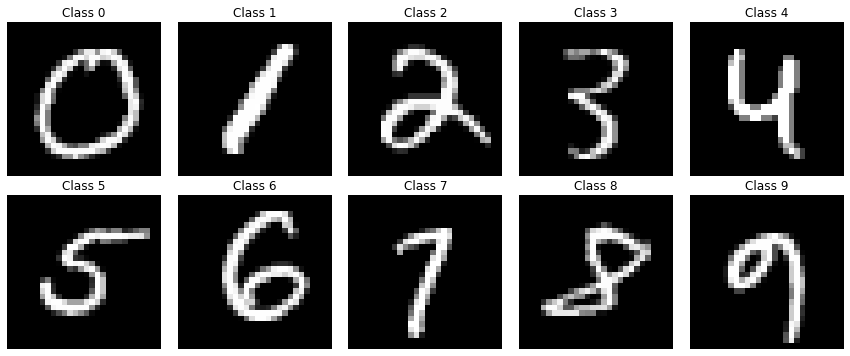

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

num_samples = 1000
transform = transforms.ToTensor()
mnist_dataset = torchvision.datasets.MNIST(root = "./data", train = True,
                                           transform = transform, download = True)

# Get the total number of data points in the dataset
total_samples = len(mnist_dataset)

# Randomly select a subset of the data
np.random.seed(13)
random_indices = np.random.choice(total_samples, num_samples, replace = False)
subset_dataset = torch.utils.data.Subset(mnist_dataset, random_indices)
# Get unique labels
unique_labels = np.unique([i[1] for i in subset_dataset])

example_images = [None] * 10
# Find and store an example image for each class
for image, label in subset_dataset:
    if any(i is None for i in example_images):
        if example_images[label] is None:
            example_images[label] = image.squeeze().numpy()
    else:
        break
# Create a subplot to display the example images
plt.figure(figsize = (12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(example_images[i], cmap = "gray")
    plt.title(f"Class {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Now we exclude the data corresponding to digit '9' and split data to train and test

In [2]:
X = subset_dataset.dataset.data[subset_dataset.indices].float().unsqueeze(1) / 255.
y = subset_dataset.dataset.targets[subset_dataset.indices]
index_9 = y == 9
X_9 = X[index_9]
y_9 = y[index_9]
X_wo_9 = X[~index_9]
y_wo_9 = y[~index_9]
X_train, X_test, y_train, y_test = train_test_split(X_wo_9, y_wo_9, test_size = 0.25,
                                                    random_state = 13, stratify = y_wo_9)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

## Model Building & Training
We will train both Bayesian and non-Bayesian models on the modified MNIST dataset. The Bayesian model will undergo training with MC Dropout, while the non-Bayesian model, serving as a baseline, will be identical but lacks dropout during testing.

We first define our custom MC dropout layer

In [3]:
class MCDropout(nn.Module):
    def __init__(self, prob = 0.5):
        super(MCDropout, self).__init__()
        self.prob = prob

    def forward(self, x):
        random_tensor = torch.rand(x.shape)
        # Create a binary mask (0 if less than dropout_prob, else 1)
        dropout_mask = (random_tensor > self.prob).float().to(device)
        x = dropout_mask * x
        return x

Now we define both models.

In [4]:
# Constants
hl_sizes = [32, 64, 128]

class NonBayesModel(nn.Module):
    def __init__(self, hl_sizes):
        super(NonBayesModel, self).__init__()
        self.initial_conv = nn.Conv2d(1, 32, kernel_size = 5, bias = False)
        self.hl_modules = nn.ModuleList()
        in_channels = 32
        for size in hl_sizes:
            self.hl_modules.append(nn.Sequential(
                nn.BatchNorm2d(in_channels),
                nn.ReLU(),
                nn.Conv2d(in_channels, size, kernel_size = 3, padding = 1, groups = in_channels, bias = False),
                nn.Conv2d(size, size, kernel_size = 1, bias = False),
                nn.BatchNorm2d(size),
                nn.ReLU(),
                nn.Conv2d(size, size, kernel_size = 3, padding = 1, groups = size, bias = False),
                nn.Conv2d(size, size, kernel_size = 1, bias = False),
                nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
            ))
            self.hl_modules.append(nn.Conv2d(in_channels, size, kernel_size = 1, stride = 2, padding = 0, bias = False))
            in_channels = size
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # normal dropout layer
        self.dropout = nn.Dropout(0.25)
        # 9 outputs only
        self.dense_out = nn.Linear(hl_sizes[-1], 9)

    def forward(self, x):
        x = self.initial_conv(x)
        for i in range(0, len(self.hl_modules), 2):
            residual = x
            x = self.hl_modules[i](x)
            residual = self.hl_modules[i+1](residual)
            x += residual
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.dense_out(x)
        return x


nonBayesModel = NonBayesModel(hl_sizes).to(device)

In [5]:
class BayesModel(nn.Module):
    def __init__(self, hl_sizes):
        super(BayesModel, self).__init__()

        self.initial_conv = nn.Conv2d(1, 32, kernel_size = 5, bias = False)
        
        self.hl_modules = nn.ModuleList()
        in_channels = 32
        for size in hl_sizes:
            self.hl_modules.append(nn.Sequential(
                nn.BatchNorm2d(in_channels),
                nn.ReLU(),
                nn.Conv2d(in_channels, size, kernel_size = 3, padding = 1, groups = in_channels, bias = False),
                nn.Conv2d(size, size, kernel_size = 1, bias = False),
                nn.BatchNorm2d(size),
                nn.ReLU(),
                nn.Conv2d(size, size, kernel_size = 3, padding = 1, groups = size, bias = False),
                nn.Conv2d(size, size, kernel_size = 1, bias = False),
                nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
            ))
            self.hl_modules.append(nn.Conv2d(in_channels, size, kernel_size = 1, stride = 2, padding = 0, bias = False))
            in_channels = size

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dense_out = nn.Linear(hl_sizes[-1], 9)

    def forward(self, x):
        x = self.initial_conv(x)
        for i in range(0, len(self.hl_modules), 2):
            residual = x
            x = self.hl_modules[i](x)
            residual = self.hl_modules[i+1](residual)
            # MC dropout upon inference as well as training
            residual = MCDropout(0.3)(residual)
            x += residual
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = MCDropout(0.3)(x)
        x = self.dense_out(x)
        return x

bayesModel = BayesModel(hl_sizes).to(device)

Now we will train both models and visualize their losses over epochs

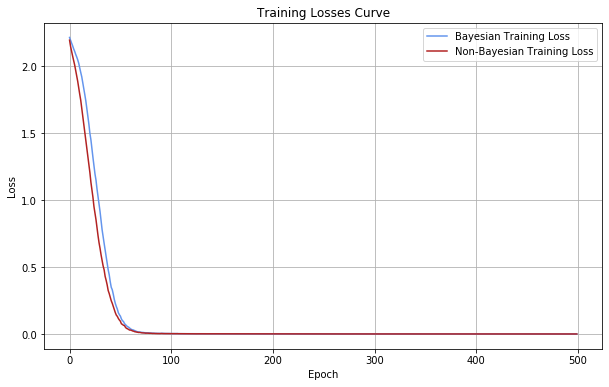

In [6]:
bayesModel.train()
nonBayesModel.train()

num_epochs = 500
lr = 0.001
criterion = nn.CrossEntropyLoss()
bayes_optimizer = optim.Adam(bayesModel.parameters(), lr = lr)
nonbayes_optimizer = optim.Adam(nonBayesModel.parameters(), lr = lr)
bayes_losses, nonbayes_losses = [], []

for epoch in range(num_epochs):
    bayes_optimizer.zero_grad()
    nonbayes_optimizer.zero_grad()

    bayes_outputs = bayesModel(X_train)
    bayes_loss = criterion(bayes_outputs, y_train)
    bayes_loss.backward()
    bayes_optimizer.step()
    bayes_losses.append(bayes_loss.item())

    nonbayes_outputs = nonBayesModel(X_train)
    nonbayes_loss = criterion(nonbayes_outputs, y_train)
    nonbayes_loss.backward()
    nonbayes_optimizer.step()
    nonbayes_losses.append(nonbayes_loss.item())


plt.figure(figsize = (10, 6))
plt.plot(range(num_epochs), bayes_losses, label = "Bayesian Training Loss", c = "cornflowerblue")
plt.plot(range(num_epochs), nonbayes_losses, label = "Non-Bayesian Training Loss", c = "firebrick")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses Curve")
plt.legend()
plt.grid(True)
plt.show()

## Accuracy Measurement
Post-training, we will evaluate and compare the accuracy of both models on the test set. The Bayesian inference is somewhat different that normal inference, we need to sample predictions i.e. instead of doing a single prediction on new data, we need to perform multiple predictions on the sama data point and take the average of the predictions as the model's output. If the model is certain, the predictions on every run won't change a lot. However, if the model is uncertain, there will be some variations in these predictions.

Despite achieving similar overall accuracy, the Bayesian model's predictions will exhibit a level of uncertainty not captured by the non-Bayesian model.

Let's look first on how accuracies change in the bayesian model on each run and how to calculate the overall accuracy on test data

In [7]:
# this won't deactivate our custom MC Dropout layer
bayesModel.eval()
accs = []
for i in range(10):
    correct = 0
    total = 0
    with torch.no_grad():
        outputs = bayesModel(X_test)
        predicted = torch.argmax(outputs, dim = 1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()

    accuracy = 100 * correct / total
    print(round(accuracy, 2))
    accs.append(accuracy)
print(f"Accuracy on validation data: {np.mean(accs):.2f}%")

95.09
92.86
94.64
94.2
95.98
95.54
93.75
94.64
95.09
95.09
Accuracy on validation data: 94.69%


We can see the change every run is so low as the model is certain about its predictions

Now we do the same with the non-Bayesian model. We don't need to do inference multiple times here but we would like to notice how the accuracies are always the same

In [8]:
# this will deactivate the traditional dropout
nonBayesModel.eval()
accs = []
for i in range(5):
    correct = 0
    total = 0
    with torch.no_grad():
        outputs = nonBayesModel(X_test)
        predicted = torch.argmax(outputs, dim = 1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()

    accuracy = 100 * correct / total
    print(round(accuracy, 2))
    accs.append(accuracy)
print(f"Accuracy on validation data: {np.mean(accs):.2f}%")

93.3
93.3
93.3
93.3
93.3
Accuracy on validation data: 93.30%


## Prediction and Visualization
To visualize the model's behavior, we will run predictions on images of the digit '9' now using both models for multiple runs. Visualizing these predictions will showcase the variability introduced by MC Dropout, providing insights into how the models respond to an unseen class. We will see how, on each run, the bayesian model is predicting a very different output hence introducing uncertainty to be further studied, while the non-Bayesian model is almost always predicting the same hence nothing to be studied.

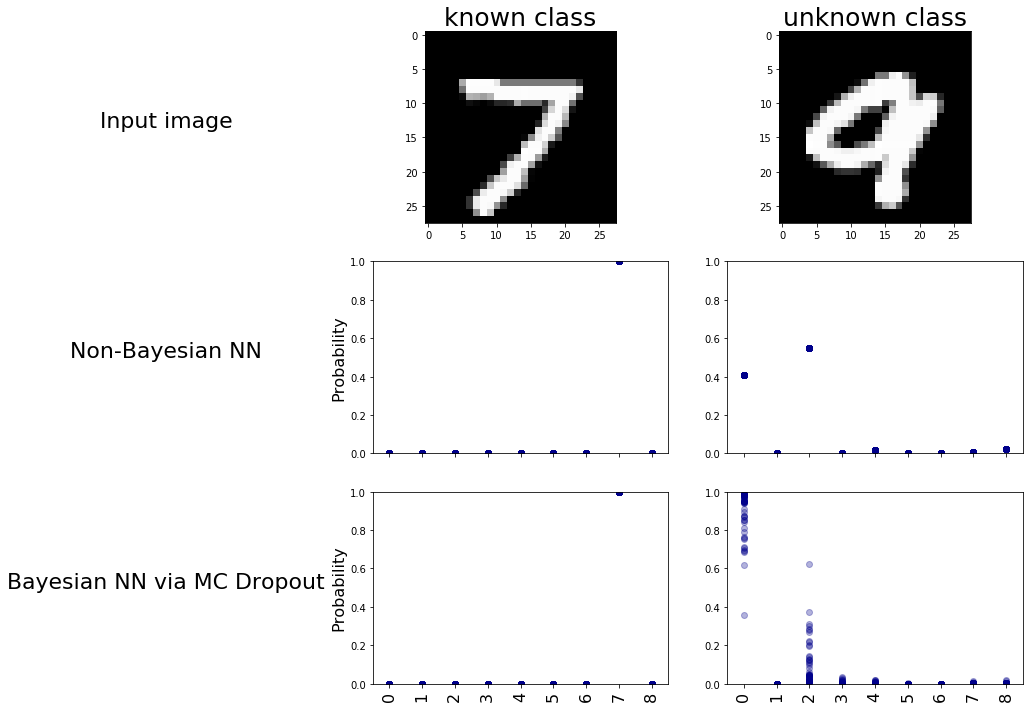

In [9]:
x_test_known = X_test[13].to(device)
y_test_known = y_test[13].to(device)

x_test_unknown = X_9[13].to(device)
y_test_unknown = y_9[13].to(device)

labels = np.unique(y_wo_9)
runs = 50
n_labels = len(labels)

plt.figure(figsize = (18, 12))

plt.subplot(3, 3, 1)
plt.axis("off")
plt.text(0.5, 0.5, "Input image", fontsize = 22, horizontalalignment = "center")
plt.subplot(3, 3, 2)
plt.imshow(x_test_known.squeeze(0).cpu(), cmap = "gray")
plt.title("known class", fontsize = 25)
plt.subplot(3, 3, 3)
plt.imshow(x_test_unknown.squeeze(0).cpu(), cmap = "gray")
plt.title("unknown class", fontsize = 25)

plt.subplot(3, 3, 4)
plt.axis("off")
plt.text(0.5, 0.5, "Non-Bayesian NN", fontsize = 22, horizontalalignment = "center")
plt.subplot(3, 3, 5)
for i in range(runs):
    plt.scatter(range(0, n_labels), F.softmax(nonBayesModel(x_test_known.unsqueeze(0)), 1).cpu().detach().numpy(), c = "darkblue", alpha = 0.3)
plt.ylabel("Probability", fontsize = 16)
plt.xticks(range(0, n_labels), labels = np.repeat(" ", n_labels))
plt.ylim([0, 1])
plt.subplot(3, 3, 6)
for i in range(runs):
    plt.scatter(range(0, n_labels), F.softmax(nonBayesModel(x_test_unknown.unsqueeze(0)), 1).cpu().detach().numpy(), c ="darkblue", alpha = 0.3)
plt.xticks(range(0, n_labels), labels = np.repeat(" ", n_labels))
plt.ylim([0, 1])

plt.subplot(3, 3, 7)
plt.axis("off")
plt.text(0.5, 0.5, "Bayesian NN via MC Dropout", fontsize = 22, horizontalalignment = "center")
plt.subplot(3, 3, 8)
for i in range(0, runs):
    plt.scatter(range(0, n_labels), F.softmax(bayesModel(x_test_known.unsqueeze(0)), 1).cpu().detach().numpy(), c = "darkblue", alpha = 0.3)
plt.xticks(range(0, n_labels), labels = labels, fontsize = 16)
plt.xticks(rotation = 90)
plt.ylim([0, 1])
plt.ylabel("Probability", fontsize = 16)
plt.subplot(3, 3, 9)
for i in range(0, runs):
    plt.scatter(range(0, n_labels), F.softmax(bayesModel(x_test_unknown.unsqueeze(0)), 1).cpu().detach().numpy(), c = "darkblue", alpha = 0.3)
plt.xticks(range(0, n_labels), labels = labels, fontsize = 16)
plt.xticks(rotation = 90)
plt.ylim([0, 1])
plt.show()

So we can clearly see the uncertainty the Bayesian model exhibits when it deals with new data it never saw before. Now let's see how we can quantify this uncertainty to somehow infer that this data point may belong to novel classes.

## Entropy Calculation
Uncertainty in Bayesian models can be quantified using entropy. For the Bayesian model, with multiple softmax outputs for each pass, we will calculate the entropy for each prediction. Comparing this against the entropy when the model predicts a known class provides a measure of uncertainty.

Entropy measures uncertainty. High entropy means the model is unsure, while low entropy means certainty and confidence. It gauges prediction confidence and helps detect anomalies. It's a really vital tool in machine learning when it comes to handling uncertainty.

Entropy is calculated via the following equation

$$
H(X) = -\sum_{i=1}^n p(x_i) \log(p(x_i))
$$

Let's put it into python code

In [10]:
def calculate_entropy(probabilities):
    # Ensure probabilities sum to 1 for each set
    normalized_probs = probabilities / np.sum(probabilities, axis = -1, keepdims = True)
    log_probs = np.log2(np.maximum(normalized_probs, 1e-10))  # Avoid log(0)
    entropy = -np.sum(normalized_probs * log_probs, axis = -1)
    return entropy

So here how it goes:
1. The model gives a set of probabilities (probability per class summing up to 1) at each run. For example we have a new image and we run prediction for 10 times then we will get an array of shape 10x9
2. We get the average probability per class over the 10 runs so we end up with a 9-element array
3. we then use these average probabilities as input to our "calculate_entropy" function to get a single number that quantifies the model's uncertainty about the input image

So let's do this

In [11]:
probs = []
for i in range(50):
    # as this is a single image we will unsqueeze it to be 3d array to make prediction and then
    # we squeeze it back
    prob = F.softmax(bayesModel(x_test_unknown.unsqueeze(0)), 1).squeeze(0).cpu().detach().numpy()
    probs.append(prob)

mean_probs = np.array(probs).mean(axis = 0)
entropy = calculate_entropy(mean_probs)
print(entropy)

0.5525348


Now we have the entropy of an unknown class. But is this number big enough or what !? how we can use it? To be able to do this, we need to look at the entropy of the model's prediction over the known and unknown classes to try to get a threshold over which we are most likely dealing with a never-seen-before class.

## Thresholding
We'll now explore the entropy of the predictions of both known and unknown classes

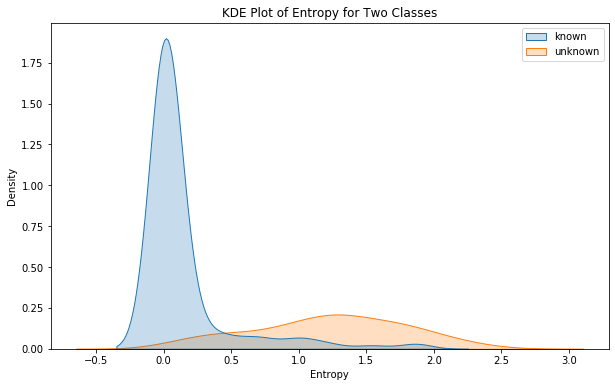

In [12]:
# we concatenate everything in a single array
all_test = torch.concatenate([X_test, X_9.to(device)])
all_y_test = torch.concatenate([y_test, y_9.to(device)]).cpu().detach().numpy()
# we change labels to only two classes (known or unknown)
all_y_test = ["known" if i < 9 else "unknown" for i in all_y_test]

probs = []
for i in range(50):
    # prob shape is (batch, n_classes)
    prob = F.softmax(bayesModel(all_test), 1).cpu().detach().numpy()
    # probs shape would be (n_runs, batch, n_classes) hence (50, len(all_y_test), 9) 
    probs.append(prob)

# we stack probs to be in the shape of (batch, n_runs, n_classes) hence (len(all_y_test), 50, 9)
# to get the 50 predictions for each data point together
probs = np.stack(probs, axis = 1)
# now we get the mean probabilities per class per image (len(all_y_test), 9)
probs_mean = np.mean(probs, axis = 1)
# we now calculate the entropy per average probabilities per image
entropies = np.apply_along_axis(calculate_entropy, axis = 1, arr = probs_mean)

plt.figure(figsize = (10, 6))
sns.kdeplot(x = entropies, hue = all_y_test, fill = True)
plt.title("KDE Plot of Entropy for Two Classes")
plt.xlabel("Entropy")
plt.ylabel("Density")
plt.show()

So Now we can clearly see that there is a difference between the entropy of the model's predictions when it is a known class and when it is unknown. To precisely determine the threshold, we will try to capture the intersection point between the entropy distribution of each class.

In [13]:
# KDE for each class
kde_known = gaussian_kde(entropies[np.array(all_y_test) == "known"])
kde_unknown = gaussian_kde(entropies[np.array(all_y_test) == "unknown"])

# generate a range of entropy values
entropy_range = np.linspace(np.min(entropies), np.max(entropies), 1000)

# calculate KDE values for both distributions
kde_known_values = kde_known(entropy_range)
kde_unknown_values = kde_unknown(entropy_range)

# finding intersection points
intersection_points = entropy_range[np.isclose(kde_known_values, kde_unknown_values, atol = 0.003)]
print(intersection_points)

[0.32499668]


So point 0.32 may suggest a very good threshold above which we may consider the data point as a new never-seen-before class.
Let's finally look where this intersection point lies in the KDE plot.

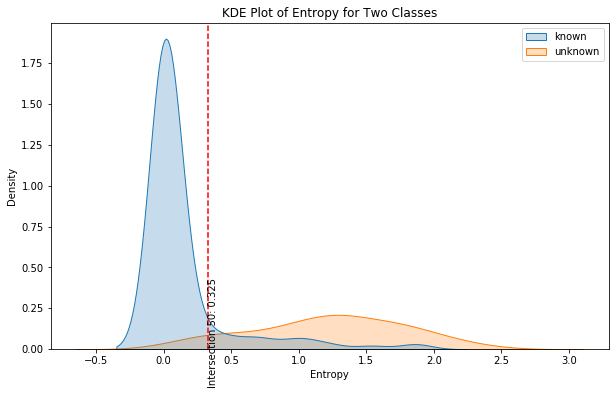

In [14]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = entropies, hue = all_y_test, fill = True)
plt.axvline(intersection_points[0], color = "red", linestyle = "--")
plt.text(intersection_points[0], 0.1, f"Intersection {i+1}: {intersection_points[0]:.3f}", rotation = 90, verticalalignment = "center")
plt.title("KDE Plot of Entropy for Two Classes")
plt.xlabel("Entropy")
plt.ylabel("Density")
plt.show()

## Conclusion
In conclusion, this tutorial has provided insights into the application of Bayesian Neural Networks for predicting novel never-seen-before classes. By leveraging uncertainty through MC Dropout and entropy analysis, we can identify unexplored categories within the dataset, highlighting the power of Bayesian models in handling unknown scenarios.